# Import delle librerie necessarie

In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
# !git clone https://github.com/AntonioDelleCanne/tesi.git

In [21]:
%cd DeepLearning_Financial

[Errno 2] No such file or directory: 'DeepLearning_Financial'
/data/home/dsvm_server_admin/notebooks/fastai/tesi/DeepLearning_Financial


In [22]:
## EXTERNAL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import yfinance
from pandas import Series
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import time
import os
import random 
from sklearn.datasets import make_regression
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from torch.nn.modules.loss import MSELoss
import tensorflow as tf
from tensorflow import keras
from skorch.dataset import CVSplit
from skorch import callbacks
import pickle
from sklearn.model_selection import train_test_split
from functools import partial
import skorch
import pywt
from sklearn import preprocessing

##INTERNAL
from models import Autoencoder, Sequence, waveletSmooth, SequenceDouble, SequenceDoubleAtt, SequenceAtt
from utils import prepare_data_lstm, ExampleDataset, save_checkpoint, evaluate_lstm, backtest

In [23]:
def save(model, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(model, f)
        
def load(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [24]:
#returns open high low close volume
def get_index(index="^DJI", start_date="2000-01-01", end_date="2018-12-31"):
    security = yfinance.Ticker(index)# TODO trova mercato asiatico e indiano
    security_data = security.history(start=start_date, end=end_date, actions=False)
    return security_data

In [25]:
def split_index(security_data):
    return security_data["Open"], security_data["High"], security_data["Low"], security_data["Close"], security_data["Volume"]

# Allenamento modello

## Metriche
Come metrica principale per valutare la bonta' dele predizioni utilizzeremo il Return of Investment (ROI).

Con questa metrica assumiamo di utilizzare l'algoritmo di trading precedentemente descritto, e calcoliamo il guadango che avremmo ottenuto se lo avessimo utilizzato sul dataset che stiamo valutando.

In [26]:
def gain(C, C_pred, opn):
    O = opn.reindex_like(C)
    CO_diff = C - O
    growth = C_pred > O
    decline = C_pred < O
    return CO_diff[growth].sum() - CO_diff[decline].sum()
def roi(C, C_pred, opn):
    mean_opn = opn.reindex_like(C).mean()
    return gain(C, C_pred, opn) / mean_opn

## Preparazione dei dati
Come spiegato in precedenza, visto che alcune feature non sono disponibili all'inizio della giornata, per poterle utilizzare nel nostro modello, utilizzeremo i dati dei giori passati, servendoci della funzione shift.

Visto che l'utilizzo di questa funzione fara' si che in alcune riche vi saranno dei vaolri NaN, dobbiamo assicurarci di eliminare queste osservazioni sia nelle serie relative ale features che in quella della variabile da predire.
Questo compito e' svolto dalla funzione prepare_data.

In [27]:
def prepare_data(features, target):
    X = pd.DataFrame(features)
    X.dropna(inplace=True)
    Y = target.reindex_like(X)
    return X, Y

Con questa funzione dividiamo i dati in training set e validation set come è stato fatto nel paper

In [28]:
def split_before_2010_06_30(X, y):
    is_train = X.index.date < datetime.date(2010,6,30)
    X_train = X.loc[is_train]
    y_train = y.loc[is_train]
    X_val = X.loc[~is_train]
    y_val = y.loc[~is_train]
    return X_train, X_val, y_train, y_val

# Preparazione del dataset

## Regolarizzazione

### Wavelet

In [87]:
def apply_wavelet_transform(data, consider_future=False, wavelet='haar'):
    serie=False
    if(type(data) is not type(pd.DataFrame())):
        data = pd.DataFrame(data)
        serie=True
    res = data.copy()
    if(len(res.shape) == 1):
        res = res[...,np.newaxis]
    if(consider_future):
        for i in range(res.shape[1]):
            res.iloc[:,i] = waveletSmooth(data.iloc[:,i].copy(), level=1, wavelet=wavelet)[-len(res):]
    else:
        for i in range(res.shape[1]):
            for j in range(res.shape[0]):
                if(j > 0):
#                     res.iloc[j,i] = waveletSmooth(data.iloc[:j,i].copy(), level=1, wavelet=wavelet)[-1]
                    w = pywt.Wavelet(wavelet)
                    cA, cD = pywt.dwt(data.iloc[:j,i].copy(), wavelet=w, mode='constant')
                    res.iloc[j,i] = cA[-1]
    if(serie):
        res = res.iloc[:,0]
    return res

## Normalizzazione 
Le seguenti funzioni sono utilizzate per normalizzare i dati, pianifichiamo di utilizzare queste funzioni anche sulla variabile da predire dovremo implementarne anche l'inversa, di modo da poter denormalizzare le predizioni fatte dal modello.
Questo passo sarà importante nella valutazione del modello, ad esempio per calcolare il ROI.

### Z score

In [30]:
#Calcola il z-score di una serie pandas
def z_score(serie):
    res = serie[1:].copy()
    for i in range(0,len(res)):
        serie_slice = serie[:i+2].copy()
        res[i] = (serie_slice[-1] - serie_slice.mean())/serie_slice.std(ddof=0)
    return res
#prede come la serie dei valori precedenti a allo z score da denormalizzare e lo z_score
def z_score_inv(past_serie, z_score):
    return z_score * past_serie.std(ddof=0) +  past_serie.mean()

## Stacked Autoencoder

In [31]:
def get_encoder(X):
    X_train_f = X.to_numpy().astype(np.float32)
    #Initialize the autoencoder
    sa_hidden_size= np.ceil(X.shape[1] / 2).astype(int) # Con tutte le features 10

    num_hidden_1 = sa_hidden_size
    num_hidden_2 = sa_hidden_size
    num_hidden_3 = sa_hidden_size
    num_hidden_4 = sa_hidden_size

    n_epoch=100#20000

    # ---- train using training data

    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    auto1 = Autoencoder(X_train_f.shape[1], num_hidden_1)
    auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    
    # Train the autoencoder 
    # switch to training mode
    auto1.train()      
    auto2.train()
    auto3.train()
    auto4.train()

    inputs = torch.from_numpy(X_train_f)
    auto1.fit(X_train_f, n_epoch=n_epoch)

    auto1_out = auto1.encoder(inputs).data.numpy()
    auto2.fit(auto1_out, n_epoch=n_epoch)


    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    auto3.fit(auto2_out, n_epoch=n_epoch)


    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    auto4.fit(auto3_out, n_epoch=n_epoch)

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    return [auto1, auto2, auto3, auto4]

In [32]:
def encode(feat_matrix, encoder):
    encoded = torch.from_numpy(feat_matrix)
    for auto in encoder:
        encoded = auto.encoder(encoded)
    return encoded.data.numpy()
    

## Selezione delle features

In [106]:
idx=get_index("^GSPC")
opn=idx["Open"]

In [112]:
ema = opn.ewm(span=20).mean()
eman = pd.Series(preprocessing.scale(opn), index=opn.index).ewm(span=20).mean()


In [107]:
#haar, coif3
opn_wt = apply_wavelet_transform(opn, wavelet="haar")

In [131]:
def zero_mean(serie):
    return pd.Series(preprocessing.scale(opn), index=opn.index)

In [134]:
coif3wt = apply_wavelet_transform(opn, wavelet="coif3")[1:]
haarwt = apply_wavelet_transform(opn, wavelet="haar")[1:]
haarwtn = apply_wavelet_transform(pd.Series(preprocessing.scale(opn), index=opn.index), wavelet="haar")[1:]
opn_p = opn[1:]

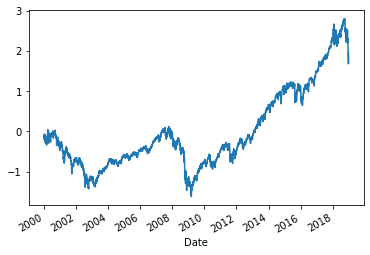

In [139]:
d =zero_mean(opn_p) - zero_mean(haarwt)
d.plot()

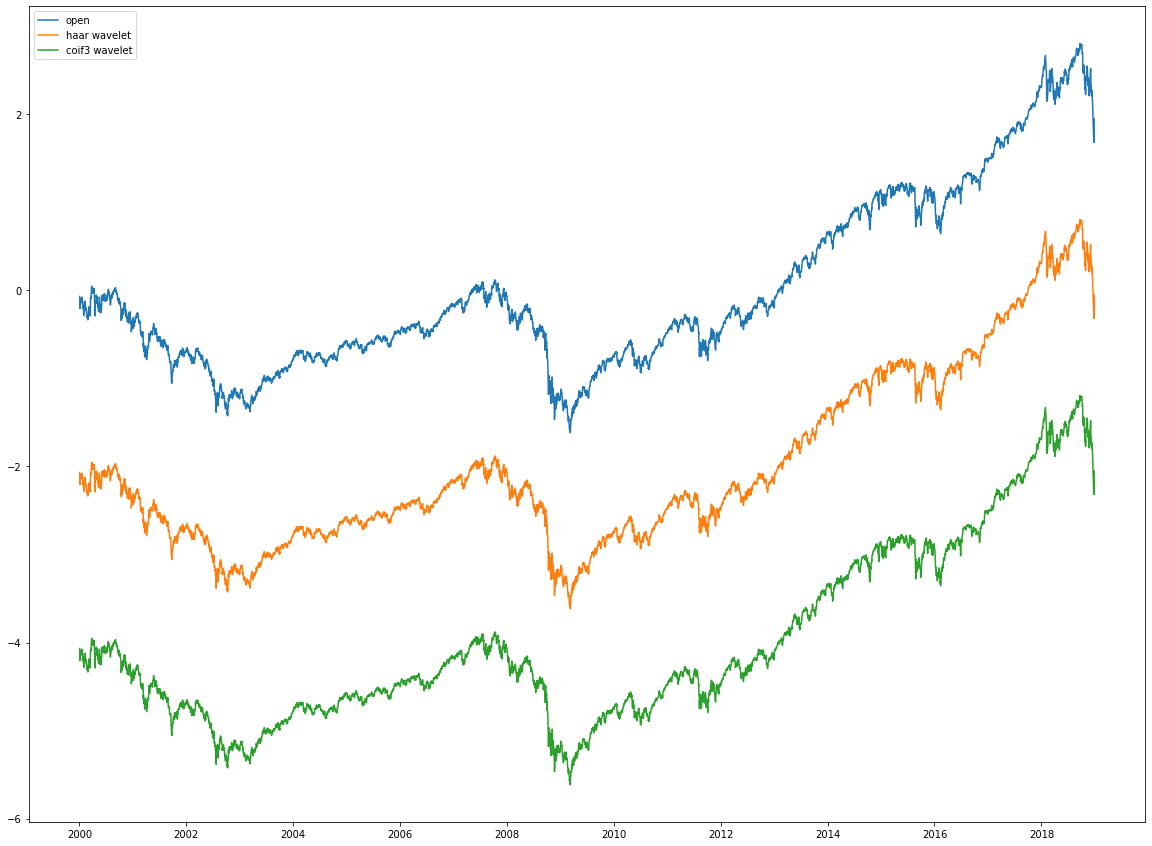

In [132]:
plt.figure(figsize=(20,15))
plt.plot(zero_mean(opn_p), label='open')
plt.plot(zero_mean(haarwt)- 2, label='haar wavelet')
plt.plot(zero_mean(coif3wt) - 4, label ='coif3 wavelet')
plt.legend()

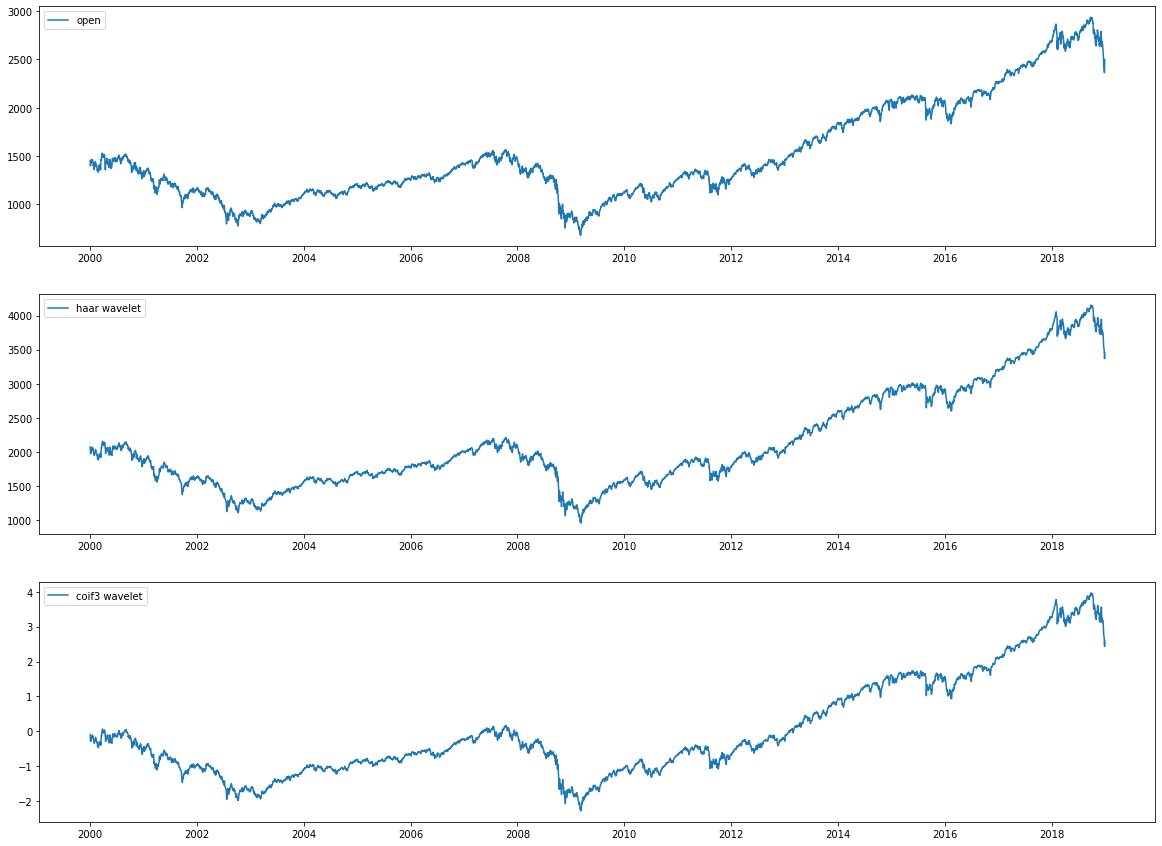

In [117]:
fig, ax = plt.subplots(3,1, sharex=False, figsize=(20,15))
ax[0].plot(opn_p, label='open')
ax[1].plot(haarwt, label='haar wavelet')
ax[2].plot(haarwtn, label ='coif3 wavelet')
ax[0].legend()
ax[1].legend()
ax[2].legend()

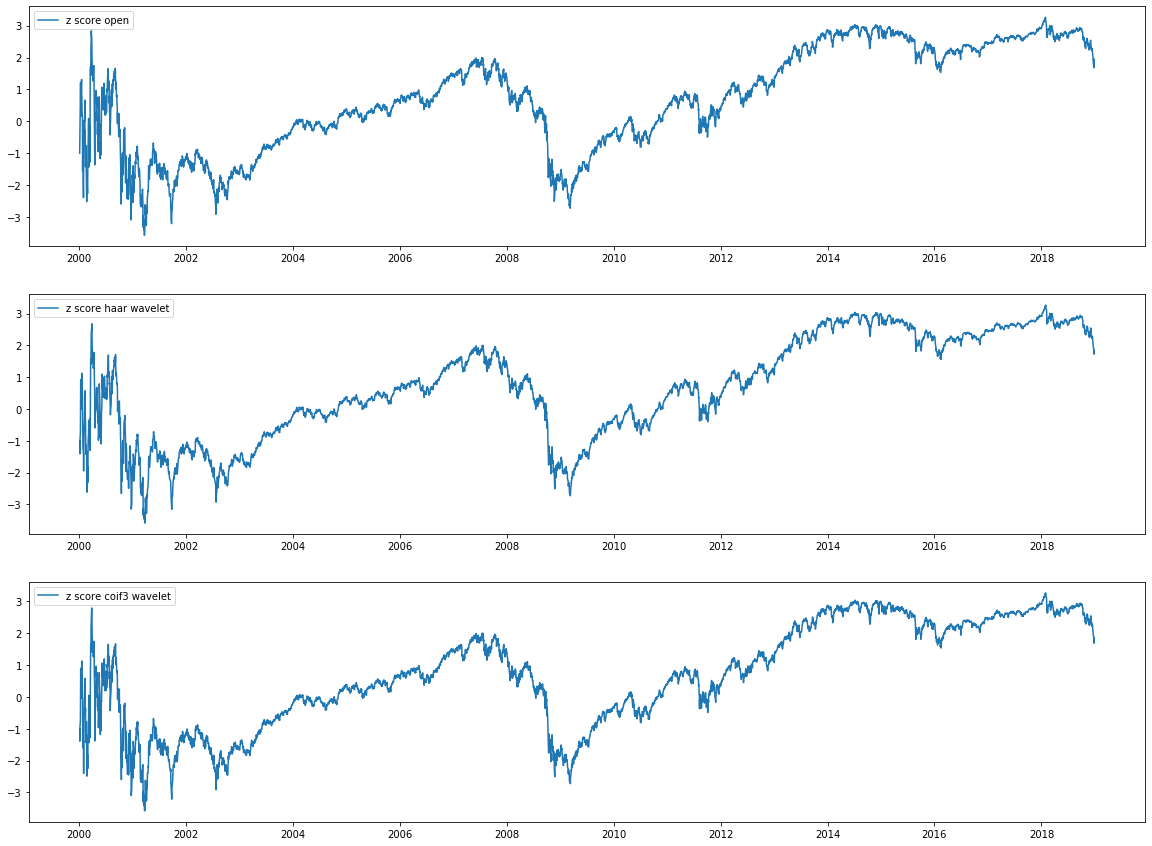

In [84]:
fig, ax = plt.subplots(3,1, sharex=False, figsize=(20,15))
ax[0].plot(z_score(opn_p), label='z score open')
ax[1].plot(z_score(haarwt), label='z score haar wavelet')
ax[2].plot(z_score(coif3wt), label ='z score coif3 wavelet')
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [52]:
get_dataset(*split_index(get_index("^DJI")), name='ohlcv_stats')

/data/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


(                Open   CloseL1    HighL1     LowL1  VolumeL1
 Date                                                        
 2000-01-06 -1.654128 -1.414214 -1.414214 -1.414214  1.414214
 2000-01-07 -0.857956 -1.452545 -1.133765 -0.556402  1.673193
 2000-01-10 -0.193796 -0.589245 -0.184303  0.253886 -0.241681
 2000-01-11  1.086004  0.977517  0.638052  1.486769  0.391032
 2000-01-12  1.083333  1.417382  1.724091  1.365912 -0.918758
 ...              ...       ...       ...       ...       ...
 2018-12-21  2.210664  2.378479  2.220298  2.234257  2.907387
 2018-12-24  2.130327  2.203283  2.102508  2.128796  3.639941
 2018-12-26  2.004856  2.195753  2.045638  2.034699  6.867708
 2018-12-27  1.900851  1.989736  1.908905  1.887199  0.930623
 2018-12-28  2.072679  2.109293  1.890096  2.129697  2.179297
 
 [4775 rows x 5 columns],
 Date
 2000-01-06   -1.452545
 2000-01-07   -0.589245
 2000-01-10    0.977517
 2000-01-11    1.417382
 2000-01-12    1.300189
                 ...   
 2018-12-21    2

In [88]:
def get_dataset(opn, close, high, low, volume, name, usd_index='DX-Y.NYB', wavelet=True, z_norm=True, zero_mean=True, encoder='ohlcv_encoder_DJIA', encoder_stats='ohlcv_stats_encoder_DJIA'):
    features={}
    dataset = None
    volume = volume/1000 # prescaling the volume
    
    us_dollar_opn = get_index(usd_index, start_date=opn.index.min(), end_date=opn.index.max())["Open"]
    
    if(wavelet):
        opn = apply_wavelet_transform(opn)
        close = apply_wavelet_transform(close)
        high = apply_wavelet_transform(high)
        low = apply_wavelet_transform(low)
        volume = apply_wavelet_transform(volume)
        us_dollar_opn = apply_wavelet_transform(us_dollar_opn)
    
    #calucate derived indicators
    TP = ((high + low + close) / 3 ).shift(1)
    trs = pd.DataFrame(index=high.index)
    trs['tr0'] = abs(high - close)
    trs['tr1'] = abs(high - close.shift(1))
    trs['tr2'] = abs(low - close.shift(1))
    TR = trs[['tr0', 'tr1', 'tr2']].max(axis=1).shift(1)
    ema20 = opn.ewm(span=20).mean()
    ma10 = opn.rolling(window=10).mean()
    ma5 = opn.rolling(window=5).mean()
    macd = opn.ewm(span=26).mean() - opn.ewm(span=12).mean()
    cci_ndays=20
    cci = (TP - TP.rolling(cci_ndays).mean()) / (0.015 * TP.rolling(cci_ndays).std())
    atr = TR.ewm(span = 10).mean()
    ma20 = opn.rolling(window=20).mean()
    std20 = opn.rolling(window=20).std()
    k=2
    boll_up =  ma20 + (k*std20)
    boll_down = ma20 - (k*std20)
    roc = (opn - opn.shift(9))*100/opn.shift(9)
    mtm6 = (opn - opn.shift(127))
    mtm12 = (opn - opn.shift(253)) #length of a trading year is on average 253 days
    wvad = (((close - low) - (high - close)) * volume/(high - low)).shift(1)
    smi = (close - (high - low)/2).shift(1)
    
    
    ohlcv_encoder = load(encoder)
#     ohlcv_stats_encoder = load(encoder_stats)
    if(z_norm):
        opn= z_score(opn)
        close = z_score(close)
        high = z_score(high)
        low = z_score(low)
        volume = z_score(volume)
    target=close
    if(name is "open"):
        features["Open"] = opn
    elif(name is "ohlcv" or "sa_ohlcv"):
        features["Open"] = opn
        features["CloseL1"] = close.shift(1)
        features["HighL1"] = high.shift(1)
        features["LowL1"] = low.shift(1)
        features["VolumeL1"] = volume.shift(1)
        if(name is "sa_ohlcv"):
            #ricava altri parametri e aggiungi a features
            temp_dset = prepare_data(features, target)
            features = {}
            for i, feature in enumerate(encode(temp_dset[0].to_numpy().astype(np.float32), ohlcv_encoder).T):
                features["deep{}".format(i)] = pd.Series(feature, index=temp_dset[0].index)
    elif(name is "ohlcv_stats" or "sa_ohlcv_stats"):
        features["Open"] = opn
        features["CloseL1"] = close.shift(1)
        features["HighL1"] = high.shift(1)
        features["LowL1"] = low.shift(1)
        features["VolumeL1"] = volume.shift(1)
        features["EMA20"] = ema20
        features["MA5"] = ma5
        features["MA10"] = ma10
        features["MA20"] = ma20
        features["MACD"] = macd
        features["CCI"] = cci
        features["ATR"] = atr
        features["BollUp"] = boll_up
        features["BollDown"] = boll_down
        features["WVAD"] = wvad
        features["MTM6"] = mtm6
        features["MTM12"] = mtm12
        features["SMI"] = smi
        features["ROC"] = roc
        features["USD_Open"] = us_dollar_opn 
        #TODO
        if(name is "sa_ohlcv_stats"):
            #ricava altri parametri e aggiungi a features
            temp_dset = prepare_data(features, target)
            features = {}
            for i, feature in enumerate(encode(temp_dset[0].to_numpy().astype(np.float32), ohlcv_encoder).T):
                features["deep{}".format(i)] = pd.Series(feature, index=temp_dset[0].index)
    else:
        raise Exception('Nome del feature-set non valido')
        
    return prepare_data(features, target)

In [631]:
index_data["EMA20"] = index_data['Open'].ewm(span=20).mean()
index_data["MA10"] = index_data['Open'].rolling(window=10).mean()
index_data["MACD"] = index_data['Open'].ewm(span=26).mean() - index_data['Open'].ewm(span=12).mean()

In [ ]:
sma_delta = delta.shift(1).rolling(window=50).mean() #simple moving average della variabile da predire calcolato sugli ultimi 50 giorni
delta_vs_sma = delta - sma_delta #differenza tra delta e il simple moving average di delta
hlm = (high + low) / 2 #prezzo medio dello stock
sma_price = hlm.shift(1).rolling(window=50).mean() #simple moving average del prezzo
price_vs_sma = hlm - sma_price #differenza tra il prezzo e il simple moving average del prezzo
sma_volume = volume.shift(1).rolling(window=50).mean() #simple moving average del volume
volume_vs_sma = volume - sma_volume #differenza tra il volume e il simple moving average del volume

## Creazione dei dataset

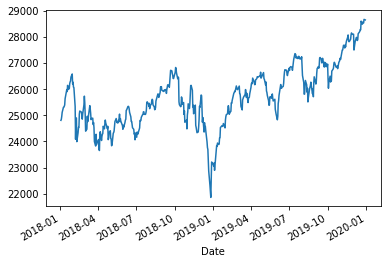

In [540]:
#parte utile per visualizzare i diversi indici da selezionare
start_date = "2000-01-01"
end_date = "2018-12-31"
security = yfinance.Ticker('ASHR')# TODO trova mercato asiatico e indiano
security_data = security.history(start=start_date, end=end_date, actions=False)
# security_data = pd.DataFrame(security_data.values, index=security_data.index[::-1], columns=security_data.columns) # inv option
opn.plot()

In [541]:
open_wt = apply_wavelet_transform(security_data["Open"])

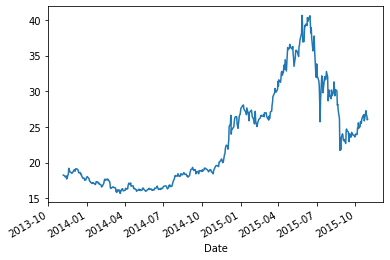

In [544]:
open_wt[:500].plot()

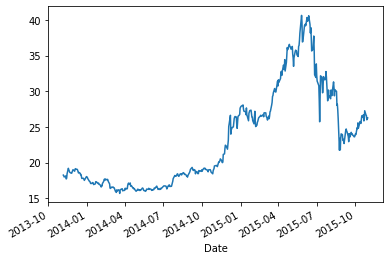

In [545]:
security_data["Open"][:500].plot()

Consideriamo i seguenti indici:
-mercati sviluppati: S&P500(^GSPC), Dow Jones Industrial Average(^DJI)
-mercati nel mezzo: Hang Seng index in Hong Kong(^HSI), Nikkei 225 index in Tokyo(^N225)
-mercati in via di sviluppo: CSI 300 in mainland China (ASHR), Nifty 50 in India(^NSEI)

In [616]:
indices = ['^GSPC', '^DJI', '^HSI', '^N225', 'ASHR','^NSEI']

In [617]:
feature_sets = ['open', 'ohlcv', 'sa_ohlcv']

In [618]:
start_date="2012-01-01"
end_date="2018-12-31"

In [619]:
# i dataset sono organizzati nel seguente modo
# -indice
#  -dati originali : dataframe pandas
#  -features: dizionario di featureset
datasets = {}
for index in indices:
    datasets[index] = {}
    datasets[index]["original"] = get_index(index=index, start_date=start_date, end_date=end_date)
    datasets[index]["features"] = {}
    for feature_set in feature_sets:
        datasets[index]["features"][feature_set] = get_dataset(*split_index(datasets[index]["original"]), name=feature_set, wavelet=True)

/data/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


## Training dei modelli

In [121]:
#dataset è della forma (X,Y)
def set_dataset(data_set):
    global X
    global Y
    global X_train
    global Y_train
    global X_val
    global Y_val
    global X_train_f
    global Y_train_f
    global X_val_f
    global Y_val_f
    global X_f
    global Y_f
    global half
    global half_split
    X= data_set[0]
    Y= data_set[1]
    X_train, X_val, Y_train, Y_val = split_before_2010_06_30(X, Y)
    X_f = X.to_numpy().astype(np.float32)
    Y_f = Y.to_numpy().astype(np.float32)[...,None]
    X_train_f = X_train.to_numpy().astype(np.float32)
    Y_train_f = Y_train.to_numpy().astype(np.float32)[...,None]
    X_val_f = X_val.to_numpy().astype(np.float32)
    Y_val_f = Y_val.to_numpy().astype(np.float32)[...,None] 
    l1 = len(np.split(X_f, [len(X_f)//2])[0])
    l2 = len(np.split(X_f, [len(X_f)//2])[1])
    half = PredefinedSplit(np.concatenate((np.ones(l1)*-1,np.ones(l2))))
    half_split =  CVSplit(cv=half, stratified=False, random_state=None)

In [255]:
# ohlcv_encoder = get_encoder(split_before_2010_06_30(data_set["ohlcv"][0], data_set["ohlcv"][1])[0])
# ohlcv_encoder = get_encoder(data_set["ohlcv"][0])

In [372]:
tss = TimeSeriesSplit(3)
tss_split = CVSplit(cv=tss, stratified=False, random_state=None)

In [373]:
half = PredefinedSplit(np.concatenate((np.ones(len(X)//2)*-1,np.ones(len(X)//2))))
half_split =  CVSplit(cv=half, stratified=False, random_state=None)

In [374]:
for i, (train, val) in enumerate(half.split(X), start=1):
    print("FOLD {}".format(i))
    train_dates = X.index[train]
    val_dates = X.index[val]
    print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
    print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))

## Metriche

In [127]:
## Calcola la loss solo sull'utlimo elemento del batch
class RNNMSELoss(MSELoss):
    def __call__(self, input, target):
        return super().__call__(input, target[-1])

## Modelli

In [37]:
# set_dataset('sa_ohlcv')

In [38]:
# # NON CONVERGE!!
# #modello del paper che usa stacked autoencoders usando LSTM originale TODO test
# n_days = 4 #nel paper chiamati delays 

# lstm_sa = NeuralNetRegressor(
#     module=Sequence,
#     optimizer=optim.Adam,
#     batch_size=n_days,
#     criterion=RNNMSELoss,
#     max_epochs=5000,
#     train_split=half_split,
    
#     module__nb_features=X.shape[1],
#     module__hidden_size=1,
#     module__nb_layers=5,
#     optimizer__lr=0.01
# )

In [39]:
# lstm_sa.fit(X_f, Y_f)

In [34]:
set_dataset('open')

In [35]:
# # modello del paper di Moro
# #SALVATO!
n_days= 10
lstm_moro = NeuralNetRegressor(
    module=SequenceDouble,
    optimizer=optim.SGD,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=200, # usato nel paper
    train_split=half_split,
#     callbacks=[callbacks.BatchScoring('accuracy', lower_is_better=False)],
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.01,
    optimizer__weight_decay=0,
    optimizer__momentum=0.9
)


In [36]:
# lstm_moro.fit(X_f,Y_f)

In [40]:
set_dataset('sa_ohlcv')

In [41]:
#modello del paper che usa stacked autoencoders usando LSTM paper Moro
# #SALVATO!
# arriva a 0.1 loss in training e validation
#SAlvato a 1000 epoche, potrebbe migliorare andando avanti
n_days = 10

lstm_sa_d = NeuralNetRegressor(
    module=SequenceDouble,#TODO usa delays come nel paper, fallo in altro modello, questo usalo per paragone
    optimizer=optim.SGD,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=1050, # trovato empiricamente 1050, da portare oltre(5000 nel paper)
    train_split=half_split,
#     callbacks=[callbacks.Checkpoint(monitor='valid_loss_best', f_pickle=None)],
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.01,
    optimizer__weight_decay=0,
    optimizer__momentum=0.9
)

In [42]:
# lstm_sa_d.fit(X_f, Y_f)

In [43]:
# save(lstm_sa_d, 'lstm_sa_d_1000')

In [74]:
set_dataset('ohlcv')

In [95]:
#modello del paper che usa attention mechanism
#Salvato accuracy 94%
n_days = 10

lstm_att_d = NeuralNetRegressor(
    module=SequenceDoubleAtt,
    optimizer=optim.Adam,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=600, # trovato 280
    train_split=half_split,
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.0001,
#     optimizer__weight_decay=0,
#     optimizer__momentum=0.9
)

In [ ]:
# lstm_att_d.fit(X_f, Y_f)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1172        0.7187  6.4809
      2        1.0034        0.5998  7.1808
      3        0.8840        0.6591  6.1611
      4        0.7984        0.4365  6.0274
      5        0.6922        0.8383  4.9582
      6        0.6131        0.6147  4.8983
      7        0.4969        0.8261  6.2194
      8        0.4653        0.3120  4.2532
      9        0.3711        0.7243  6.8349
     10        0.4107        0.2713  6.0433
     11        0.3264        0.4538  7.0782
     12        0.3413        0.2125  6.8971
     13        0.3014        0.1398  4.8922
     14        0.2883        0.1048  3.9719
     15        0.2764        0.0873  7.3364
     16        0.2675        0.0826  7.8844
     17        0.2582        0.0871  7.1083
     18        0.2551        0.0758  6.8948
     19        0.2514        0.0877  5.7369
     20        0.2488        0.0727  4.2753
     21        0.2481        0.0

    163        0.1556        0.2006  4.6121
    164        0.1551        0.2658  5.2178
    165        0.1603        0.2401  5.8900
    166        0.1585        0.2449  7.1737
    167        0.1575        0.2238  4.6052
    168        0.1544        0.2593  6.7709
    169        0.1547        0.2235  6.0914
    170        0.1536        0.2359  5.3163
    171        0.1560        0.2854  5.5693
    172        0.1639        0.2550  5.0595
    173        0.1654        0.2330  6.8731
    174        0.1619        0.3086  5.2706
    175        0.1568        0.2091  6.5499
    176        0.1548        0.1732  6.0210
    177        0.1540        0.1839  6.5787
    178        0.1532        0.2620  4.3068
    179        0.1525        0.1877  4.4146
    180        0.1519        0.1182  6.2053
    181        0.1539        0.2734  5.1855
    182        0.1568        0.3231  7.6910
    183        0.1561        0.2027  4.4865
    184        0.1546        0.1834  6.5276
    185        0.1605        0.2

    355        0.1094        0.2152  5.7333
    356        0.1096        0.1388  8.1066
    357        0.1097        0.4203  6.3318
    358        0.1095        0.2442  6.3795


In [ ]:
save(lstm_att_d, 'lstm_att_d_600')

In [152]:
set_dataset('sa_ohlcv')

In [171]:
#modello del paper che usa attention mechanism
n_days = 10

lstm_sa_att_d = NeuralNetRegressor(
    module=SequenceDoubleAtt,
    optimizer=optim.Adam,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=1500,
    train_split=half_split,
    callbacks=[callbacks.Checkpoint(monitor='valid_loss_best', f_pickle='lstm_sa_att_sa_best')],
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.0001,
#     optimizer__weight_decay=0,
#     optimizer__momentum=0.9
)

In [172]:
# lstm_sa_att_d.fit(X_f, Y_f)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        1.7839        1.7800     +  4.2405
      2        2.5504        2.6548        5.3017
      3        2.2136        3.2959        6.9751
      4        2.0680        3.3661        7.4058
      5        2.0567        3.4067        6.1896
      6        2.0513        3.4322        4.5342
      7        2.0478        3.4533        4.6748
      8        2.0453        3.4689        7.1891
      9        2.0435        3.4812        5.1962
     10        2.0420        3.4910        5.6740
     11        2.0408        3.4986        4.0372
     12        2.0398        3.5045        3.8377
     13        2.0390        3.5090        4.7327
     14        2.0382        3.5123        5.3868
     15        2.0376        3.5145        6.1007
     16        2.0370        3.5158        6.1171
     17        2.0365        3.5160        7.4258
     18        2.0361        3.5151        4.3187


    142        0.4249        0.3583     +  6.7847
    143        0.4246        0.3504     +  6.4393
    144        0.4243        0.3429     +  6.4200
    145        0.4241        0.3359     +  4.0451
    146        0.4240        0.3295     +  6.0599
    147        0.4241        0.3233     +  6.8835
    148        0.4241        0.3171     +  7.2345
    149        0.4242        0.3105     +  4.2761
    150        0.4243        0.3035     +  4.3664
    151        0.4243        0.2955     +  5.1292
    152        0.4241        0.2855     +  6.8771
    153        0.4232        0.2724     +  6.1437
    154        0.4217        0.2612     +  6.7296
    155        0.4206        0.2559     +  7.2518
    156        0.4196        0.2534     +  5.0444
    157        0.4189        0.2521     +  6.0494
    158        0.4184        0.2515     +  5.5473
    159        0.4181        0.2510     +  4.4922
    160        0.4179        0.2504     +  6.3585
    161        0.4178        0.2496     +  7.1236


    264        0.3762        0.1658     +  5.6431
    265        0.3758        0.1652     +  5.4582
    266        0.3753        0.1646     +  6.0638
    267        0.3749        0.1640     +  6.2720
    268        0.3744        0.1634     +  6.4638
    269        0.3740        0.1628     +  4.3130
    270        0.3735        0.1621     +  5.8668
    271        0.3731        0.1614     +  5.2198
    272        0.3726        0.1607     +  5.8014
    273        0.3722        0.1600     +  6.0212
    274        0.3717        0.1592     +  5.0230
    275        0.3713        0.1584     +  6.6747
    276        0.3708        0.1575     +  5.9522
    277        0.3703        0.1566     +  4.7165
    278        0.3698        0.1556     +  9.4451
    279        0.3694        0.1546     +  7.1359
    280        0.3689        0.1536     +  4.8861
    281        0.3684        0.1526     +  6.9417
    282        0.3679        0.1515     +  4.0355
    283        0.3675        0.1504     +  5.9228


    407        0.3210        0.1390        6.1094
    408        0.3206        0.1184        5.8244
    409        0.3348        0.1218        4.6093
    410        0.3238        0.1232        6.7165
    411        0.3222        0.1238        7.4552
    412        0.3213        0.1317        6.7779
    413        0.3217        0.1256        7.4123
    414        0.3245        0.1287        5.4001
    415        0.3178        0.2274        6.5596
    416        0.3205        0.1272        6.3485
    417        0.3262        0.1772        3.9647
    418        0.3232        0.1210        8.2824
    419        0.3878        0.1418        4.7741
    420        0.3438        0.1181        5.3736
    421        0.3265        0.2002        5.6828
    422        0.3206        0.1294        6.0018
    423        0.3212        0.1261        4.1353
    424        0.3196        0.1301        6.1077
    425        0.3195        0.1198        7.0416
    426        0.3160        0.1592        6.0528


    566        0.3071        0.1071        8.6022
    567        0.3277        0.1221        6.0972
    568        0.3109        0.1249        6.5752
    569        0.3040        0.1086        7.2947
    570        0.3019        0.1421        4.6529
    571        0.2979        0.1168        6.2189
    572        0.2987        0.1497        4.0250
    573        0.2918        0.1243        4.1171
    574        0.2888        0.1536        6.5913
    575        0.3003        0.1333        6.1366
    576        0.2937        0.1055        6.1435
    577        0.3025        0.1550        6.2186
    578        0.3037        0.1101        6.6456
    579        0.3084        0.1443        6.2086
    580        0.2999        0.1992        5.9685
    581        0.3083        0.1004        7.2323
    582        0.3032        0.0933        7.3401
    583        0.3194        0.3034        6.5570
    584        0.3046        0.1248        5.4772
    585        0.3027        0.1174        5.7903


    731        0.2773        0.2808        6.4075
    732        0.2728        0.5528        4.8699
    733        0.2708        0.4272        4.9357
    734        0.2708        0.6607        5.2813
    735        0.2706        0.9280        5.0484
    736        0.2700        1.0474        4.2587
    737        0.2718        1.1107        4.2149
    738        0.2723        0.5133        5.8186
    739        0.2705        0.1903        3.8090
    740        0.2798        0.1150        6.7268
    741        0.2780        1.3535        5.9312
    742        0.2817        0.3421        6.2788
    743        0.2994        0.0913        9.5038
    744        0.2854        0.2737        7.0770
    745        0.2736        0.2908        7.4948
    746        0.2743        0.1763        5.4175
    747        0.2699        0.3086        6.1331
    748        0.2685        0.2840        5.9482
    749        0.2682        0.3254        4.1816
    750        0.2682        0.5009        4.9735


    888        0.2260        0.2677        4.5779
    889        0.2262        0.3011        4.8172
    890        0.2228        0.2512        4.2755
    891        0.2246        0.3991        6.0313
    892        0.2250        0.3320        6.2728
    893        0.2286        0.1473        3.7447
    894        0.2323        0.3012        3.7351
    895        0.2209        0.8718        4.4156
    896        0.2242        1.3990        5.8967
    897        0.2234        0.3884        3.9455
    898        0.2236        0.2659        5.9154
    899        0.2191        0.2599        6.6534
    900        0.2248        0.3547        6.0654
    901        0.2346        0.2939        6.3623
    902        0.2330        0.7307        4.4547
    903        0.2653        0.0822        4.2373
    904        0.2461        0.1037        4.2733
    905        0.2312        0.1498        4.6442
    906        0.2363        0.1489        4.3075
    907        0.2258        0.2418        9.9381


   1052        0.1937        0.3789        10.1175
   1053        0.2677        0.3813        4.5194
   1054        0.2588        0.1783        5.8730
   1055        0.2116        0.2175        6.0162
   1056        0.2004        0.3355        5.1124
   1057        0.1989        0.5047        8.6493
   1058        0.1990        0.3794        5.4653
   1059        0.1964        0.3433        4.4031
   1060        0.1940        0.3903        4.9055
   1061        0.1931        0.3785        6.2057
   1062        0.1924        0.3337        4.5515
   1063        0.1919        0.2968        6.5250
   1064        0.1912        0.2528        5.9127
   1065        0.1917        0.2631        6.5138
   1066        0.1914        0.2369        6.5009
   1067        0.1914        0.2474        7.8871
   1068        0.1947        0.2960        5.9448
   1069        0.2222        0.4066        6.0630
   1070        0.3175        0.0770        6.1122
   1071        0.2583        0.2118        6.5176

   1213        0.1817        0.2254        5.6052
   1214        0.1813        0.2919        7.0677
   1215        0.1820        0.3246        7.0023
   1216        0.1836        0.4094        3.9665
   1217        0.1816        0.2095        4.0115
   1218        0.1854        0.1102        5.2363
   1219        0.1875        0.1022        6.5669
   1220        0.2172        0.5050        6.8788
   1221        0.2686        0.1117        6.1189
   1222        0.2310        0.3021        7.0959
   1223        0.2119        0.2538        6.6033
   1224        0.2253        0.1661        7.4843
   1225        0.2126        0.1919        5.5113
   1226        0.2570        0.1927        7.0541
   1227        0.2353        0.1938        6.3954
   1228        0.2219        0.2149        4.4586
   1229        0.2032        0.1522        10.1648
   1230        0.2058        0.1554        7.3929
   1231        0.2373        0.1278        9.0502
   1232        0.1991        0.1493        6.3546

   1376        0.1885        0.1264        7.2386
   1377        0.1867        0.1229        6.1631
   1378        0.1849        0.1266        8.1151
   1379        0.1836        0.1300        6.0480
   1380        0.1826        0.1329        4.2940
   1381        0.1817        0.1342        5.9262
   1382        0.1806        0.1370        7.4632
   1383        0.1799        0.1346        5.6567
   1384        0.1793        0.1446        4.7475
   1385        0.1806        0.0911        6.7550
   1386        0.1825        0.2188        5.6639
   1387        0.1857        0.2141        5.7345
   1392        0.1831        0.1874        4.4179
   1393        0.1838        0.1659        4.8239
   1394        0.1801        0.1498        5.3897
   1395        0.1798        0.1354        5.3573
   1396        0.1794        0.1290        5.5750
   1397        0.1786        0.1258        6.7855
   1398        0.1780        0.1259        5.6788
   1399        0.1783        0.1442        4.6592


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SequenceDoubleAtt(
    (lstm1): LSTM(3, 256)
    (lstm2): LSTM(256, 512)
    (lin): Linear(in_features=512, out_features=1, bias=True)
    (softmax): Softmax(dim=0)
  ),
)

In [175]:
# save(lstm_sa_att_d, 'lstm_sa_att_sa_1500')

## Valutazione del training

In [263]:
# lstm_test = lstm_sa_att_d

In [106]:
# lstm_test.history[10].keys()

dict_keys(['batches', 'epoch', 'train_batch_count', 'valid_batch_count', 'dur', 'train_loss', 'train_loss_best', 'valid_loss', 'valid_loss_best'])

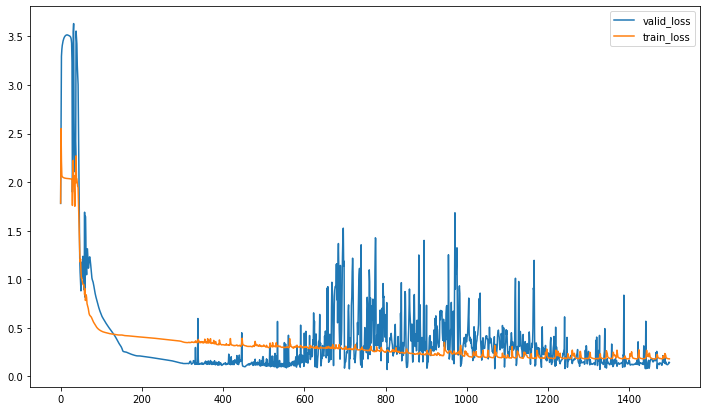

In [178]:
# lstm = lstm_test
# valid_losses = lstm.history[:, 'valid_loss']
# train_losses = lstm.history[:, 'train_loss']
# plt.figure(figsize=(12,7))
# plt.plot(valid_losses, label='valid_loss')
# plt.plot(train_losses, label='train_loss')
# # plt.xticks(np.arange(len(valid_losses)+1, step=50))
# plt.legend()

# Test
Dopo aver trovato i parametri migliori i modelli vengono testati facendo training sulla metà dei dati e predizioni sull'altra metà

In [615]:
datasets.keys()

dict_keys(['^GSPC'])

In [99]:
# models = ['lstm_sa_d', 'lstm_moro', 'lstm_sa_d_1000', 'lstm_att_d_600', 'lstm_sa_att_sa_1500']

In [610]:
models = [('lstm_moro', 'open'), ('lstm_sa_d_1000','sa_ohlcv'), ('lstm_att_d_600','ohlcv'), ('lstm_sa_att_1500', 'ohlcv')]

In [611]:
model = models[0]

In [516]:
lstm_test = load(model[0])

In [612]:
datasets["^GSPC"]["features"].keys()

dict_keys([])

In [613]:
market = "^DJI"
feature_set = model[1]

In [614]:
datasets[market]["original"]["Open"].plot()

KeyError: '^DJI'

In [520]:
set_dataset(datasets[market]["features"][feature_set])
opn = datasets[market]["original"]["Open"]
close = datasets[market]["original"]["Close"]

In [521]:
# i primi 51 giorni non vengonon considerati poichè servono per il calcolo dell'inversa dello z_index
Y_original = close.copy()
Y_preds = Y_original.copy()

for i in range(51, len(Y_val)): 
    pred = lstm_test.predict(X_val[i-10:i].to_numpy().astype(np.float32))[0] #in input vengono dati 10 gionri
    #denormalization
    previous_serie = Y_original[:i]
    Y_preds[i] = z_score_inv(previous_serie[-50:], pred) #il z score viene calcolato su 50 gionri
Y_preds = Y_preds[51:]
Y_original = Y_original.reindex_like(Y_preds, copy=False)

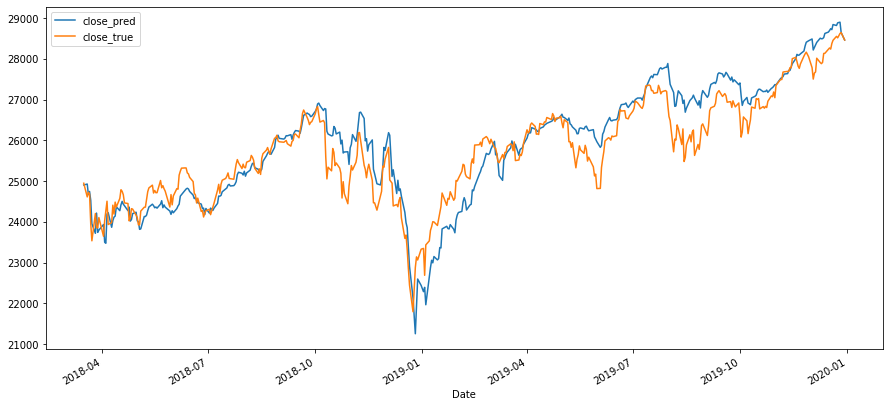

In [522]:
plt.figure(figsize=(15,7))
Y_preds.plot(label='close_pred')
Y_original.plot(label='close_true')
plt.legend()

In [556]:
Y_original.max()

28645.26

In [557]:
sklearn.metrics.mean_squared_error(Y_original, Y_preds)

279257.32989513554

In [608]:
score = pd.Series(index=["MAPE","RMSPE", "R2", "ROI", "ROI Ideal", "ROI vs ideal"], dtype=np.float32)
score["MAPE"] = sklearn.metrics.mean_absolute_error(Y_original, Y_preds)/Y_preds.mean()
score["RMSPE"] = np.sqrt(sklearn.metrics.mean_squared_error(Y_original, Y_preds))/Y_original.mean()
score["R2"] = sklearn.metrics.r2_score(Y_original, Y_preds)
score["ROI"] = roi(Y_original,Y_preds, opn)
score["ROI Ideal"] = roi(Y_original,Y_original, opn)
score["ROI vs ideal"] = abs(roi(Y_original,Y_preds, opn) - roi(Y_original,Y_original, opn))

In [609]:
score

MAPE            0.016101
RMSPE           0.020515
R2              0.805406
ROI            -0.337720
ROI Ideal       2.357970
ROI vs ideal    2.695689
dtype: float32

In [454]:
scores = pd.DataFrame(index=score.index)


In [535]:
show_transaction = False
initial_capital = 10000
capital = initial_capital
cap_history = Y_preds.copy()
holding=False
opns = opn.reindex_like(Y_preds).copy()
buy_history = opn.reindex_like(Y_preds).copy()
sell_history = opn.reindex_like(Y_preds).copy()
for date in Y_preds.index:
    buy_history[date] = None
    sell_history[date] = None
    pred = Y_preds[date]
    true = Y_original[date]
    buy = Y_preds[date] - opns[date] > 0
    delta_true = Y_original[date] - opns[date]
    if(buy and not holding): # buy
        if(show_transaction):
            capital -= opns[date]
        holding = True
        buy_history[date] = capital
    elif(not buy and holding): #sell
        if(show_transaction):
            capital += opns[date]
        holding = False
        sell_history[date] = capital
    if(holding):
        capital+= delta_true
    cap_history[date] = capital
if(holding and show_transaction):
    capital += opns[-1]
    holding = False
abs_gain = capital - initial_capital
perc_gain = (abs_gain) / initial_capital
print(f"guadagno assoluto: {abs_gain}")
print(f"guadagno percentuale: {perc_gain}")

guadagno assoluto: -4225.680000000029
guadagno percentuale: -0.42256800000000294


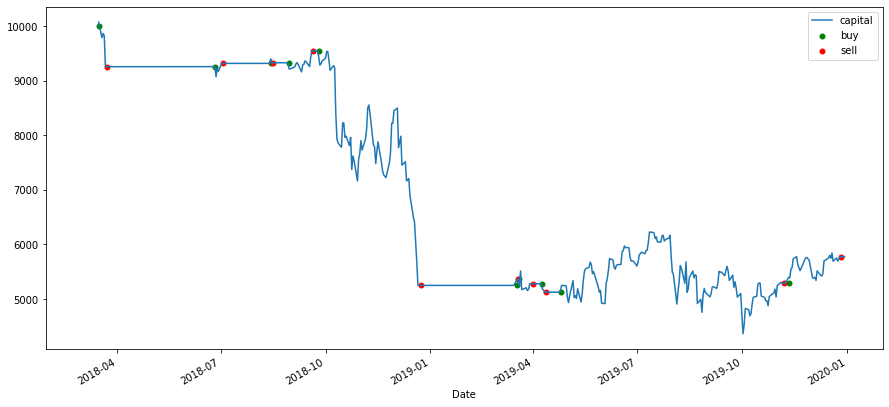

In [536]:
plt.figure(figsize=(15,7))
plt.scatter(buy_history.index, buy_history, c='green', label='buy', linewidths=0.001)
plt.scatter(sell_history.index, sell_history, c= 'red', label='sell', linewidths=0.001)
cap_history.plot(label='capital')
plt.legend()